In [1]:
import requests
import pandas as pd
import time

API_KEY = "your-api-key"
SYMBOL = "HSBC"   # Use US ADR
BASE_URL = "https://www.alphavantage.co/query"

def fetch_statement(function_name, max_retries=5):
    params = {
        "function": function_name,
        "symbol": SYMBOL,
        "apikey": API_KEY
    }

    for attempt in range(max_retries):
        response = requests.get(BASE_URL, params=params)
        data = response.json()

        # Rate limit hit
        if "Information" in data:
            print("⚠️ Rate limit hit. Waiting 15 seconds...")
            time.sleep(15)
            continue

        # API error
        if "Error Message" in data:
            raise RuntimeError(data["Error Message"])

        # Success
        if "annualReports" in data:
            return pd.DataFrame(data["annualReports"])

        print("⚠️ Unexpected response, retrying...")
        time.sleep(10)

    raise RuntimeError("Failed to fetch data after multiple retries")

# ============================
# Fetch statements (slow & safe)
# ============================
income = fetch_statement("INCOME_STATEMENT")
time.sleep(15)

balance = fetch_statement("BALANCE_SHEET")
time.sleep(15)

cashflow = fetch_statement("CASH_FLOW")

# ============================
# Clean annual data
# ============================
def clean_annual(df):
    df["fiscalDateEnding"] = pd.to_datetime(df["fiscalDateEnding"])
    df["Year"] = df["fiscalDateEnding"].dt.year
    df = df.sort_values("Year")
    df.reset_index(drop=True, inplace=True)
    return df

income_clean = clean_annual(income)
balance_clean = clean_annual(balance)
cashflow_clean = clean_annual(cashflow)

# ============================
# Save outputs
# ============================
income_clean.to_csv("hsbc_income_statement_annual.csv", index=False)
balance_clean.to_csv("hsbc_balance_sheet_annual.csv", index=False)
cashflow_clean.to_csv("hsbc_cash_flow_annual.csv", index=False)

print("✅ Financial statements downloaded successfully")
print("Years available:", income_clean["Year"].tolist())


✅ Financial statements downloaded successfully
Years available: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [2]:
import pandas as pd

# Load data
income = pd.read_csv("hsbc_income_statement_annual.csv")
balance = pd.read_csv("hsbc_balance_sheet_annual.csv")



In [3]:
# Convert to numeric (important for Alpha Vantage data)
numeric_cols_income = [
    "totalRevenue", "netIncome", "operatingExpenses"
]
numeric_cols_balance = [
    "totalAssets", "totalShareholderEquity"
]

for col in numeric_cols_income:
    income[col] = pd.to_numeric(income[col], errors="coerce")

for col in numeric_cols_balance:
    balance[col] = pd.to_numeric(balance[col], errors="coerce")

# Merge statements
df = pd.merge(
    income,
    balance,
    on=["fiscalDateEnding", "Year"],
    how="inner"
)



## Financial Ratio & Trend Analysis

In [4]:
# ============================
# Calculate bank-specific ratios
# ============================

df["ROE"] = df["netIncome"] / df["totalShareholderEquity"]
df["ROA"] = df["netIncome"] / df["totalAssets"]
df["Cost_to_Income"] = df["operatingExpenses"] / df["totalRevenue"]
df["Equity_to_Assets"] = df["totalShareholderEquity"] / df["totalAssets"]

# Keep clean output
ratios = df[[
    "Year",
    "ROE",
    "ROA",
    "Cost_to_Income",
    "Equity_to_Assets"
]].sort_values("Year")

print(ratios.round(4))

    Year     ROE     ROA  Cost_to_Income  Equity_to_Assets
0   2005  0.1632  0.0100          0.4458            0.0615
1   2006  0.1457  0.0085          0.4262            0.0582
2   2007  0.1493  0.0081          0.4406            0.0544
3   2008  0.0612  0.0023          0.5648            0.0370
4   2009  0.0455  0.0025          0.7086            0.0543
5   2010  0.0891  0.0054          0.6121            0.0602
6   2011  0.1058  0.0066          0.5783            0.0621
7   2012  0.0800  0.0052          0.5769            0.0651
8   2013  0.0891  0.0061          0.5780            0.0681
9   2014  0.0719  0.0052          0.6146            0.0723
10  2015  0.0717  0.0056          0.6154            0.0782
11  2016  0.0141  0.0010          0.7357            0.0738
12  2017  0.0568  0.0043          0.6080            0.0754
13  2018  0.0737  0.0054          0.5286            0.0728
14  2019  0.0401  0.0027          0.6029            0.0678
15  2020  0.0266  0.0018          0.7036            0.06

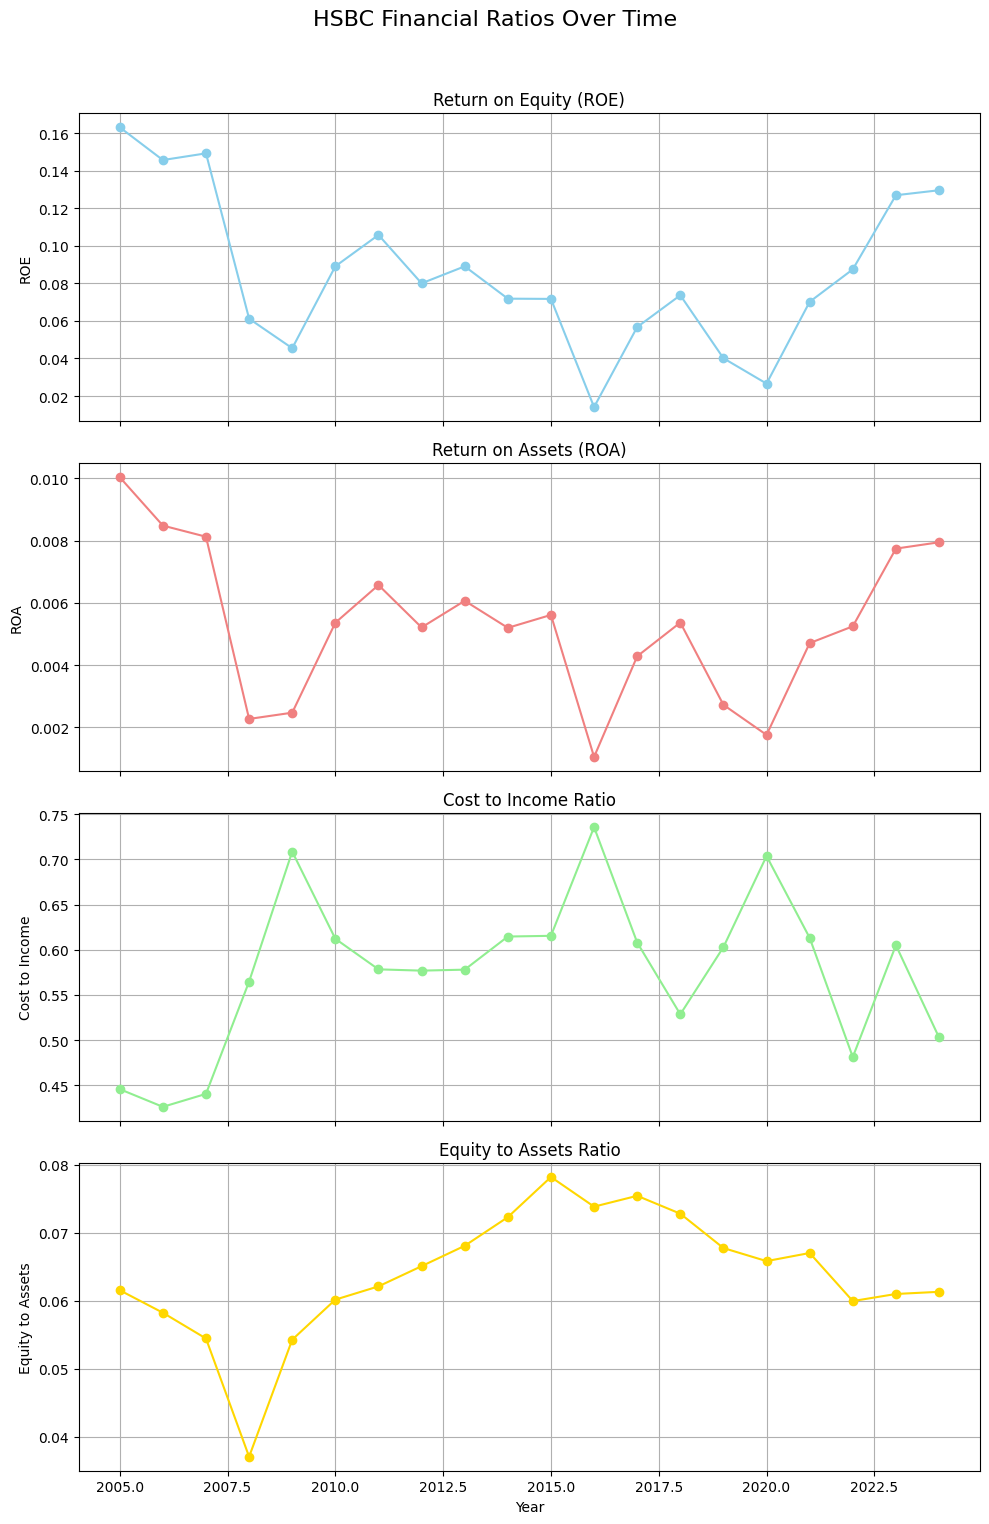

In [5]:
import matplotlib.pyplot as plt

# Create subplots for each ratio
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 16), sharex=True)
fig.suptitle('HSBC Financial Ratios Over Time', fontsize=16)

# Plot ROE
axes[0].plot(ratios['Year'], ratios['ROE'], marker='o', color='skyblue')
axes[0].set_title('Return on Equity (ROE)')
axes[0].set_ylabel('ROE')
axes[0].grid(True)

# Plot ROA
axes[1].plot(ratios['Year'], ratios['ROA'], marker='o', color='lightcoral')
axes[1].set_title('Return on Assets (ROA)')
axes[1].set_ylabel('ROA')
axes[1].grid(True)

# Plot Cost to Income Ratio
axes[2].plot(ratios['Year'], ratios['Cost_to_Income'], marker='o', color='lightgreen')
axes[2].set_title('Cost to Income Ratio')
axes[2].set_ylabel('Cost to Income')
axes[2].grid(True)

# Plot Equity to Assets Ratio
axes[3].plot(ratios['Year'], ratios['Equity_to_Assets'], marker='o', color='gold')
axes[3].set_title('Equity to Assets Ratio')
axes[3].set_xlabel('Year')
axes[3].set_ylabel('Equity to Assets')
axes[3].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent title overlap
plt.show()

In [6]:
import plotly.express as px

# Create interactive line plot for ROE
fig_roe = px.line(ratios, x='Year', y='ROE', title='Return on Equity (ROE) Over Time')
fig_roe.show()

# Create interactive line plot for ROA
fig_roa = px.line(ratios, x='Year', y='ROA', title='Return on Assets (ROA) Over Time')
fig_roa.show()

# Create interactive line plot for Cost to Income Ratio
fig_cti = px.line(ratios, x='Year', y='Cost_to_Income', title='Cost to Income Ratio Over Time')
fig_cti.show()

# Create interactive line plot for Equity to Assets Ratio
fig_eta = px.line(ratios, x='Year', y='Equity_to_Assets', title='Equity to Assets Ratio Over Time')
fig_eta.show()


## Revenue & Net Income Forecast

In [7]:
# Sort by year
income = income.sort_values("Year").reset_index(drop=True)

In [8]:
# ----------------------------
# Calculate historical growth
# ----------------------------
income["Revenue_Growth"] = income["totalRevenue"].pct_change()
income["NetIncome_Growth"] = income["netIncome"].pct_change()

# Use average growth rate (exclude NaNs)
rev_cagr = income["Revenue_Growth"].mean()
ni_cagr = income["NetIncome_Growth"].mean()

print(f"Average Revenue Growth: {rev_cagr:.2%}")
print(f"Average Net Income Growth: {ni_cagr:.2%}")


Average Revenue Growth: -0.96%
Average Net Income Growth: 27.89%


In [9]:
# ----------------------------
# Forecast next 3 years
# ----------------------------
forecast_years = 3
last_year = income.loc[income.index[-1], "Year"]
last_revenue = income.loc[income.index[-1], "totalRevenue"]
last_net_income = income.loc[income.index[-1], "netIncome"]

forecast = []

for i in range(1, forecast_years + 1):
    year = last_year + i
    revenue = last_revenue * ((1 + rev_cagr) ** i)
    net_income = last_net_income * ((1 + ni_cagr) ** i)

    forecast.append({
        "Year": year,
        "Forecast_Revenue": revenue,
        "Forecast_NetIncome": net_income
    })

forecast_df = pd.DataFrame(forecast)

print("\nForecast:")
print(forecast_df.round(2))


Forecast:
   Year  Forecast_Revenue  Forecast_NetIncome
0  2025      6.066702e+10        3.066657e+10
1  2026      6.008664e+10        3.921925e+10
2  2027      5.951182e+10        5.015720e+10


In [10]:
# Create interactive line plot for forecasted revenue
fig_forecast_revenue = px.line(forecast_df, x='Year', y='Forecast_Revenue', title='Forecasted Revenue Over Time')
fig_forecast_revenue.show()

# Create interactive line plot for forecasted net income
fig_forecast_net_income = px.line(forecast_df, x='Year', y='Forecast_NetIncome', title='Forecasted Net Income Over Time')
fig_forecast_net_income.show()

## Valuation

In [11]:

forecast = forecast_df if False else None

last_net_income = income.iloc[-1]["netIncome"]
avg_growth = income["netIncome"].pct_change().mean()

forecast_years = 3
pe_multiple = 8

future_earnings = last_net_income * ((1 + avg_growth) ** forecast_years)
intrinsic_value_proxy = future_earnings * pe_multiple

print(f"Forecasted Net Income (Year +{forecast_years}): {future_earnings:,.0f}")
print(f"Implied Intrinsic Value (Proxy): {intrinsic_value_proxy:,.0f}")


Forecasted Net Income (Year +3): 50,157,203,069
Implied Intrinsic Value (Proxy): 401,257,624,548


In [12]:
latest_year = income.sort_values("Year").iloc[-1]
net_income = latest_year["netIncome"]

print(f"Latest Year: {latest_year['Year']}")
print(f"Net Income: {net_income:,.0f}")

# ----------------------------
# Relative valuation assumptions
# ----------------------------
pe_low = 7
pe_mid = 8
pe_high = 9

valuation = {
    "P/E Multiple": ["7x (Bear)", "8x (Base)", "9x (Bull)"],
    "Implied Equity Value": [
        net_income * pe_low,
        net_income * pe_mid,
        net_income * pe_high
    ]
}

valuation_df = pd.DataFrame(valuation)

print("\nRelative Valuation (Earnings-based):")
print(valuation_df)


Latest Year: 2024
Net Income: 23,979,000,000

Relative Valuation (Earnings-based):
  P/E Multiple  Implied Equity Value
0    7x (Bear)          167853000000
1    8x (Base)          191832000000
2    9x (Bull)          215811000000


In [13]:
growth_rates = [0.02, 0.04, 0.06]   # 2%, 4%, 6%
pe_multiples = [7, 8, 9]

rows = []

for g in growth_rates:
    for pe in pe_multiples:
        future_earnings = net_income * ((1 + g) ** 3)
        value = future_earnings * pe
        rows.append({
            "Growth Rate": f"{int(g*100)}%",
            "P/E Multiple": f"{pe}x",
            "Implied Value": round(value, 0)
        })

sensitivity_df = pd.DataFrame(rows)
print(sensitivity_df)

  Growth Rate P/E Multiple  Implied Value
0          2%           7x   1.781269e+11
1          2%           8x   2.035737e+11
2          2%           9x   2.290204e+11
3          4%           7x   1.888118e+11
4          4%           8x   2.157849e+11
5          4%           9x   2.427580e+11
6          6%           7x   1.999156e+11
7          6%           8x   2.284750e+11
8          6%           9x   2.570344e+11
